# Parametric Model-Based regression

    Notebook version: 1.0 (Sep 23, 2016)

    Author: Jesús Cid-Sueiro (jesus.cid@uc3m.es)
            Jerónimo Arenas García (jarenas@tsc.uc3m.es)

    Changes: v.1.0 - First version, expanding some cells from the Bayesian Regression 
                     notebook
    
    Pending changes: * Include regression on the stock data

In [1]:
# Import some libraries that will be necessary for working with data and displaying plots

# To visualize plots in the notebook
%matplotlib inline 

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.io       # To read matlab files
import pylab

## 1. Model-based parametric regression

### 1.1. The regression problem

Given an observation vector ${\bf x}$, the goal of the regression problem is to find a function $f({\bf x})$ providing *good* predictions about some unknown variable $s$. To do so, we assume that a set of *labelled* training examples, $\{{\bf x}^{(k)}, s^{(k)}\}_{k=1}^K$ is available. 

The predictor function should make good predictions for new observations ${\bf x}$ not used during training. In practice, this is tested using a second set (the *test set*) of labelled samples.

### 1.2. The i.i.d. assumption

Most regression algorithms are grounded on the idea that all samples from the training and test sets have been generated independently by some common stochastic process. This is the reason why a model adjusted with the training data can make good predictions over new test samples. 

Mathematically, this means that all pairs $({\bf x}^{(k)}, s^{(k)})$ from the training and test sets are independent and identically distributed (i.i.d.) samples from some distribution $p_{{\bf X}, S}({\bf x}, s)$. Unfortunately, this distribution is generally unknown.

<img src="figs/DataModel.png", width=180>

NOTE: In the following, we will use capital letters, ${\bf X}$, $S$, ..., to denote random variables, and lower-case letters ${\bf x}$, s, ..., to the denote the values they can take. When there is no ambigüity, we will remove subindices of the density functions, $p_{{\bf X}, S}({\bf x}, s)= p({\bf x}, s)$ to simplify the mathematical notation.

### 1.3. Model-based regression

If $p({\bf x}, s)$ were know, we could apply estimation theory to estimate $s$ from $p$. For instance, we could apply any of the following classical estimates:

* Maximum A Posterior (MAP): $$\hat{s}_{\text{MAP}} = \arg\max_s p(s| {\bf x})$$
* Minimum Mean Square Error (MSE): $$\hat{s}_{\text{MSE}} = \mathbb{E}\{S |{\bf x}\}$$

Note that, since these estimators depend on $p(s |{\bf x})$, knowing the posterior distribution of the target variable is enough, and we do not need to know the joint distribution.

Model based-regression methods exploit the idea of using the training data to estimate the posterior distribution $p(s|{\bf x})$ and then apply estimation theory to make predictions.

<img src="figs/ModelBasedReg.png", width=280>

### 1.4. Parametric model-based regression

How can we estimate the posterior probability function of the target variable $s$? In this section we will explore a parametric estimation method: let us assume that $p$ belongs to a parametric family of distributions $p(s|{\bf x},{\bf w})$, where ${\bf w}$ is some unknown parameter. We will use the training data to estimate ${\bf w}$

<img src="figs/ParametricReg.png", width=300>

The estimation of ${\bf w}$ from a given dataset $\mathcal{D}$ is the goal of the following sections

### 1.5. Maximum Likelihood parameter estimation.

The ML (Maximum Likelihood) principle is well-known in statistics and can be stated as follows: take the value of the parameter to be estimated (in our case, ${\bf w}$) that best explains the given observations (in our case, the training dataset $\mathcal{D}$). Mathematically, this can be expressed as follows:
$$
\hat{\bf w}_{\text{ML}} = \arg \max_{\bf w} p(\mathcal{D}|{\bf w})
$$

To be more specific: let us group the target variables into a vector
$$
{\bf s} = \left(s^{(1)}, \dots, s^{(K)}\right)^\top
$$
and the input vectors into a matrix
$$
{\bf X} = \left({\bf x}^{(1)}, \dots, {\bf x}^{(K)}\right)^\top
$$

Then we can write 

$$p(\mathcal{D}|{\bf w}) 
    = p({\bf s}, {\bf X}|{\bf w}) 
    = p({\bf s} | {\bf X}, {\bf w}) p({\bf X}|{\bf w})
    = p({\bf s} | {\bf X}, {\bf w}) p({\bf X})
$$
(where, in the last step, we have used the fact that the inputs do not depend on ${\bf w}$, which is a parameter of the posterior distribution of $s$).

Thus, we can express the estimation problem in
$$
\hat{\bf w}_{\text{ML}} = \arg \max_{\bf w} p({\bf s}|{\bf X},{\bf w})
$$

### 1.6. Summary.

Let's summarize what we need to do in order to design a regression algorithm:

1. Assume a parametric data model $p(s| {\bf x},{\bf w})$
2. Using the data model and the i.i.d. assumption, compute $p({\bf s}| {\bf X},{\bf w})$.
3. Find an expression for ${\bf w}_{\text{ML}}$
4. Assuming ${\bf w} = {\bf w}_{\text{ML}}$, compute the MAP or the minimum MSE estimate of $s$ given ${\bf x}$.

## 2. ML estimation for a Gaussian model.

### 2.1. Step 1: The Gaussian generative model

Let us assume that the target variables $s^{(k)}$ in dataset $\mathcal{D}$ are given by
$$
s^{(k)} = {\bf w}^\top {\bf z}^{(k)} + \varepsilon^{(k)}
$$

where ${\bf z}^{(k)}$ is the result of some transformation of the inputs, ${\bf z}^{(k)} = T({\bf x}^{(k)})$, and $\varepsilon^{(k)}$ are i.i.d. instances of a Gaussian random variable with mean zero and varianze $\sigma_\varepsilon^2$, i.e.,
$$
p_E(\varepsilon) = \frac{1}{\sqrt{2\pi}\sigma_\varepsilon}
                   \exp\left(-\frac{\varepsilon^2}{2\sigma_\varepsilon^2}\right)
$$

Assuming that the noise variables are independent on ${\bf x}$ and ${\bf w}$, then, for a given ${\bf x}$ and ${\bf w}$, the target variable is gaussian with mean ${\bf w}^\top {\bf z}^{(k)}$ and variance $\varepsilon^2$
$$
p(s|{\bf x}, {\bf w}) = p_E(s-{\bf w}^\top{\bf z}) =
    \frac{1}{\sqrt{2\pi}\sigma_\varepsilon}
    \exp\left(-\frac{(s-{\bf w}^\top{\bf z})^2}{2\sigma_\varepsilon^2}\right)
$$

### 2.2. Step 2: Likelihood function

Now we need to compute the likelihood function $p({\bf s}, {\bf X} | {\bf w})$. If the samples are i.i.d. we can write
$$
p({\bf s}| {\bf X}, {\bf w})
    = \prod_{k=1}^{K} p(s^{(k)}| {\bf x}^{(k)}, {\bf w}) 
    = \prod_{k=1}^{K} \frac{1}{\sqrt{2\pi}\sigma_\varepsilon}
    \exp\left(-\frac{\left(s^{(k)}-{\bf w}^\top{\bf z}^{(k)}\right)^2}{2\sigma_\varepsilon^2}\right) \\
    = \left(\frac{1}{\sqrt{2\pi}\sigma_\varepsilon}\right)^K
      \exp\left(-\sum_{k=1}^K \frac{\left(s^{(k)}-{\bf w}^\top{\bf z}^{(k)}\right)^2}{2\sigma_\varepsilon^2}\right) \\
$$
Finally, grouping variables ${\bf z}^{(k)}$ in
$${\bf Z} = \left({\bf z}^{(1)}, \dots, {\bf z}^{(K)}\right)^\top$$
we get
$$
p({\bf s}| {\bf X}, {\bf w})
    = \left(\frac{1}{\sqrt{2\pi}\sigma_\varepsilon}\right)^K
      \exp\left(-\frac{1}{2\sigma_\varepsilon^2}\|{\bf s}-{\bf Z}{\bf w}\|^2\right)
$$

### 2.3. Step 3: ML estimation.

The <b>maximum likelihood</b> solution is then given by:
$$
{\bf w}_{ML} = \arg \max_{\bf w} p({\bf s}|{\bf w}) = \arg \min_{\bf w} \|{\bf s} - {\bf Z}{\bf w}\|^2
$$

Note that this is exactly the same optimization problem of the Least Squares (LS) regression algorithm. The solution is
$$
{\bf w}_{ML} = ({\bf Z}^\top{\bf Z})^{-1}{\bf Z}^\top{\bf s}
$$


### 2.4. Step 4: Prediction function.

The last step consists on computing an estimate of $s$ by assuming that the true value of the weight parameters is ${\bf w}_\text{ML}$. In particular, the minimum MSE estimate is
$$
\hat{s}_\text{MSE} = \mathbb{E}\{s|{\bf x},{\bf w}_\text{ML}\}
$$
Knowing that, given ${\bf x}$ and ${\bf w}$, $s$ is normally distributed with mean ${\bf w}^\top {\bf z}$ we can write
$$
\hat{s}_\text{MSE} = {\bf w}_\text{ML}^\top {\bf z}
$$




#### Exercise 1:

Assume that the targets in the one-dimensional dataset given by

In [3]:
X = np.array([0.15, 0.41, 0.53, 0.80, 0.89, 0.92, 0.95]) 
s = np.array([0.09, 0.16, 0.63, 0.44, 0.55, 0.82, 0.95]) 

have been generated by a linear Gaussian model (i.e., with $z = T(x) = x$) with noise variance 


In [4]:
sigma_eps = 0.3

* **1.1.** Represent a scatter plot of the data points

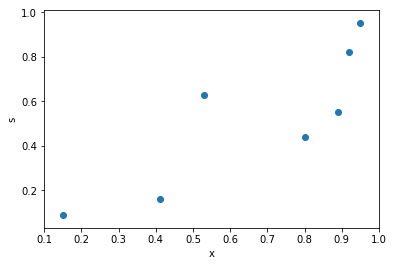

In [5]:
# <SOL>
plt.figure()
plt.scatter(X, s)
plt.xlabel('x')
plt.ylabel('s')
plt.show()
# </SOL>

* **1.2.** Compute the ML estimate.

In [6]:
# <SOL>
# Note that, to use lstsq, the input matrix must be K x 1
Xcol = X[:,np.newaxis]
wML = np.linalg.lstsq(Xcol, s)[0]
# </SOL>

* **1.3.** Plot the likelihood as a function of parameter $w$ along the interval $-0.5\le w \le 2$, verifying that the ML estimate takes the maximum value.

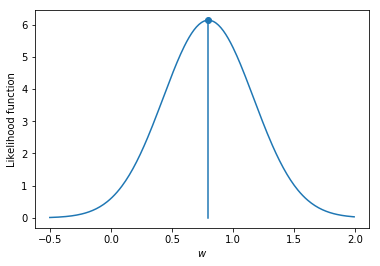

In [7]:
# <SOL>
K = len(s)
wGrid = np.arange(-0.5, 2, 0.01)

p = []
for w in wGrid:
    d = s - X*w
    p.append((1.0/(np.sqrt(2*np.pi)*sigma_eps))**K * np.exp(-np.dot(d, d)))

d = s-X*wML
pML = [(1.0/(np.sqrt(2*np.pi)*sigma_eps))**K * np.exp(-np.dot(d, d))]

plt.figure()
plt.plot(wGrid, p)
plt.stem(wML, pML)
plt.xlabel('$w$')
plt.ylabel('Likelihood function')
plt.show()
# </SOL>

* **1.4.** Plot the prediction function over the data scatter plot 

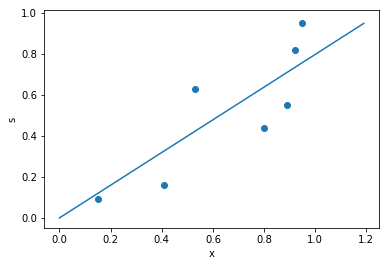

In [8]:
# <SOL>
x = np.arange(0, 1.2, 0.01)
sML = wML * x

plt.figure()
plt.scatter(X, s)
plt.plot(x, sML)
plt.xlabel('x')
plt.ylabel('s')
plt.axis('tight')
plt.show()
# </SOL>

#### Exercise 2:

Assume the dataset $\mathcal{D} = \{(x^{(k)}, s^{(k)}, k=1,\ldots, K\}$ contains i.i.d. samples from a distribution with posterior density given by
$$
p(s|x, w) = w x \exp(- w x s), \qquad s\ge0, \,\, x\ge 0, \,\, w\ge 0
$$

* **2.1.** Determine an expression for the likelihood function

**Solution**:

<SOL>
The likelihood function is 
$$
p({\bf s}|w, {\bf X}) 
    = \prod_{k=1}^K w x^{(k)} \exp(- w x^{(k)} s^{(k)})
    = w^K \left(\prod_{k=1}^K x^{(k)}\right)  \exp\left(- w \sum_{k=1}^K x^{(k)} s^{(k)}\right)
$$
</SOL>

* **2.2.** Draw the likelihood function for the dataset in **Exercise 1** in the range $0\le w\le 6$.

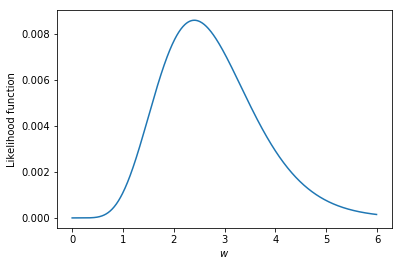

In [9]:
# <SOL>
K = len(s)
wGrid = np.arange(0, 6, 0.01)

p = []
Px = np.prod(X)
xs = np.dot(X,s)
for w in wGrid:
    p.append((w**K)*Px*np.exp(-w*xs))

plt.figure()
plt.plot(wGrid, p)
plt.xlabel('$w$')
plt.ylabel('Likelihood function')
plt.show()
# </SOL>

* **2.3.** Determine the coefficient $w_\text{ML}$ of the linear prediction function (i.e., using ${\bf Z}={\bf X}$). 
(*Hint: you can maximize the log of the likelihood function instead of the likelihood function in order to simplify the differentiation*)

**Solution**:

Applyng the logarithm to the likelihood function we get
$$
\log p({\bf s}|{\bf w}, {\bf X}) 
    = K\log  w + \sum_{k=1}^K \log\left(x^{(k)}\right)  - w {\bf X}^\top {\bf s}
$$
Whis is minimum for 
$$
w_\text{ML} = \frac{K}{{\bf X}^\top {\bf s}}
$$

</SOL>

* **2.4.** Compute $w_\text{ML}$ for the dataset in **Exercise 1**

In [12]:
wML = np.float(K) /xs
print(wML)

2.40434155389


### 2.4. Multiple explanations of the data

With an additive Gaussian independent noise model, the maximum likelihood and the least squares solutions are the same. We have not improved much ...

However, we have already formulated the problem in a probabilistic way. This opens the door to reasoning in terms of a set of possible explanations, not just one. We believe more than one of our models could have generated the data.

   - We do not believe all models are equally likely to have generated the data
   - We may <b>believe</b> that a simpler model is more likely than a complex one